In [2]:
## IMPORT PACKAGES

import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
import xgboost as xgb

In [3]:
# Set parameters
timetrain = 1639 # number of days for training (default until May 25 2019: we want two years simulation)
timetrail = 30 # number of days before to look at
locality = 14 # number of days before and after for a price to be a local low or local high

In [6]:
## LOAD DATA AND PREPROCESS
data = pd.read_csv('Bitstamp_BTCUSD_d_Recent.csv', header=1, index_col=1) # load dataset and plot (data starts Nov. 28, 2014)
data = data.iloc[0:,2:] # prepare table
data = pd.DataFrame(data.iloc[::-1]) # reverse table and turn to Data Frame
data['volume'] = data['Volume BTC'] + data['Volume USD'] # preprocess (add volume btc and volume usd)
data = data[['close','volume']] # prepare new table with only close and volume USD

# Get train data
traindf = data.iloc[:timetrain+1,] # get train data
trainscaler = MinMaxScaler(feature_range=(0, 1)) # initialize scaler
trainscaled = pd.DataFrame(trainscaler.fit_transform(traindf)) # scale data for better learning
trainscaled.columns = ('close','volume') # give label to columns

# Prepare time shifted train data table
trainscaled.index = traindf.index # give label to rows
newcols, newcols_names = list(), list() # initialize time shifted data table
for i in range(timetrail, 0, -1):  # prepare time shifted data table
    newcols.append(trainscaled.shift(i))
    newcols_names.append(('close(t-%d)' % i,'volume(t-%d)' % i))
trainshifted = pd.concat(newcols, axis=1) # finalize time shifted data table
trainshifted.columns = list(sum(newcols_names, ())) # give label to columns

In [12]:
# prepare train data
trainX = pd.DataFrame(trainshifted.iloc[timetrail:trainshifted.shape[0],].values) # set train attributes and response
pricetrainY = pd.DataFrame(trainscaled['close'].iloc[timetrail:trainshifted.shape[0],].values) # set train attributes and response

#auto-manually set the buy and sell signals if local high/low else hold
signal = list()
signalsell = list()
signalbuy = list()
checkprice = np.zeros(locality*2+1)
for i in range(locality,len(pricetrainY.values)-locality):
    for j in range(i-locality,i+locality+1):
        checkprice[j-i+locality]=pricetrainY.values[j]
    if(pricetrainY.values[i]==max(checkprice)):
        signal.append('SELL')
        signalsell.append(pricetrainY.values[i])
        signalbuy.append(0)
    elif(pricetrainY.values[i]==min(checkprice)):
        signal.append('BUY')
        signalbuy.append(pricetrainY.values[i])
        signalsell.append(0)
    else:
        signal.append('HOLD')
        signalsell.append(0)
        signalbuy.append(0)
        
#finalize training classification data
finaltrainX = trainX.iloc[locality:(len(pricetrainY.values)-locality),:]
finaltrainX.columns = trainshifted.columns
finaltrainY = pd.DataFrame(signal)

<ipython-input-14-75a7342847d6>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  plotsell=pd.DataFrame(np.array(signalsell))
<ipython-input-14-75a7342847d6>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  plotbuy=pd.DataFrame(np.array(signalbuy))


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

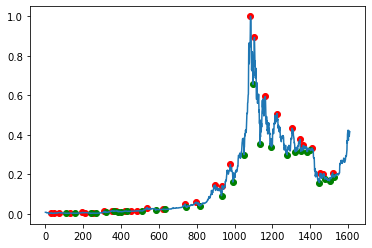

In [14]:
#plot buy and sell signals
plotsell=pd.DataFrame(np.array(signalsell))
plotbuy=pd.DataFrame(np.array(signalbuy))
pyplot.figure()
pyplot.scatter(range(locality,(len(signalsell)+locality)),plotsell[plotsell!=0],color='red')
pyplot.scatter(range(locality,(len(signalbuy)+locality)),plotbuy[plotbuy!=0],color='green')
pyplot.plot(pricetrainY)
pyplot.plot

In [16]:
# train XGBoost classifier
classes_weights = class_weight.compute_sample_weight('balanced',finaltrainY)
XGB = xgb.XGBClassifier(learning_rate=0.01, colsample_bytree = 0.6, subsample = 0.8, objective='binary:logistic', n_estimators=1000, reg_alpha = 0.3, max_depth=4, gamma=10).fit(finaltrainX,finaltrainY,sample_weight=classes_weights)

C:\Users\Janni\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Janni\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[14:17:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [18]:
## TEST DATA

# Get test data
testdf = data.iloc[(timetrain+1):,] # get test data
testscaler = MinMaxScaler(feature_range=(0, 1)) # initialize scaler
testscaled = pd.DataFrame(testscaler.fit_transform(testdf)) # scale data for better learning
testscaled.columns = ('close','volume') # give label to columns

# Prepare time shifted test data table
testscaled.index = testdf.index # give label to rows
newcols, newcols_names = list(), list() # initialize time shifted data table
for i in range(timetrail, 0, -1): # prepare time shifted data table
    newcols.append(testscaled.shift(i))
    newcols_names.append(('close(t-%d)' % i,'volume(t-%d)' % i))
testshifted = pd.concat(newcols, axis=1) # finalize time shifted data table
testshifted.columns = list(sum(newcols_names, ())) # give label to columns

# finalize test data
testX = pd.DataFrame(testshifted.iloc[timetrail:,].values) # set train attributes and response
pricetestY = pd.DataFrame(testscaled['close'].iloc[timetrail:testshifted.shape[0],].values) # set train attributes and response
testX.columns = testshifted.columns

<ipython-input-20-38bfa26944bb>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  testplotsell=pd.DataFrame(np.array(testsignalsell))
<ipython-input-20-38bfa26944bb>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  testplotbuy=pd.DataFrame(np.array(testsignalbuy))


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

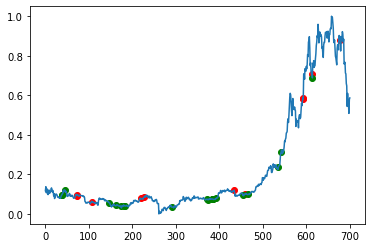

In [20]:
# predict using XGBoost
XGBpredY = XGB.predict(testX) # make predictions using model

# prepare buy/sell signal order
testsignalsell = list()
testsignalbuy = list()
for k in range(len(XGBpredY)):
    if XGBpredY[k] == 'BUY':
        testsignalbuy.append(pricetestY.values[k])
        testsignalsell.append(0)
    elif XGBpredY[k] == 'SELL':
        testsignalbuy.append(0)
        testsignalsell.append(pricetestY.values[k])
    else:
        testsignalbuy.append(0)
        testsignalsell.append(0)

# plot buy and sell signals as predicted
testplotsell=pd.DataFrame(np.array(testsignalsell))
testplotbuy=pd.DataFrame(np.array(testsignalbuy))
pyplot.figure() # plot training data
pyplot.scatter(range(len(testsignalsell)),testplotsell[testplotsell!=0],color='red')
pyplot.scatter(range(len(testsignalbuy)),testplotbuy[testplotbuy!=0],color='green')
pyplot.plot(pricetestY)
pyplot.plot

In [61]:
## SIMULATION
trueprice=pd.DataFrame(data['close'].values) # get true (non-scaled) prices of test data
testtrueprice=trueprice.iloc[len(data)-len(pricetestY):,] # adjust so same timeframe

money = 100000
state = 'HOLD'
shares = 0
for a in range(len(testtrueprice)):
    if XGBpredY[a] == 'BUY' and state != 'BUY':
        shares = (money/testtrueprice.values[a])*0.99
        money = 0
        print('Bought at %.3f, Coins held: %.3f, Money now: %.2f' % (testtrueprice.values[a], shares/50, money))
        state = 'BUY'
    if XGBpredY[a] == 'SELL' and state == 'BUY':
        money = shares*testtrueprice.values[a]*0.99
        shares = 0
        print('Sold at %.3f, Coins held: %.3f, Money now: %.2f' % (testtrueprice.values[a], shares/50, money))
        state = 'SELL'

Bought at 10407.710, Coins held: 0.190, Money now: 0.00
Sold at 10573.660, Coins held: 0.000, Money now: 99572.76
Bought at 8170.650, Coins held: 0.241, Money now: 0.00
Sold at 9500.000, Coins held: 0.000, Money now: 113469.18
Bought at 6908.240, Coins held: 0.325, Money now: 0.00
Sold at 11923.960, Coins held: 0.000, Money now: 191955.88
Bought at 10411.290, Coins held: 0.365, Money now: 0.00
Sold at 10689.810, Coins held: 0.000, Money now: 193168.92
Bought at 10669.630, Coins held: 0.358, Money now: 0.00
Sold at 39282.100, Coins held: 0.000, Money now: 697032.42
Bought at 45240.960, Coins held: 0.305, Money now: 0.00
Sold at 56622.660, Coins held: 0.000, Money now: 855030.92


<ipython-input-71-a90312e742ec>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  testplotsell=pd.DataFrame(np.array(testsignalsell))
<ipython-input-71-a90312e742ec>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  testplotbuy=pd.DataFrame(np.array(testsignalbuy))


Bought at 10772.220, Coins held: 0.184, Money now: 0.00
Sold at 10401.600, Coins held: 0.000, Money now: 94637.95
Bought at 10573.660, Coins held: 0.177, Money now: 0.00
Sold at 10368.650, Coins held: 0.000, Money now: 90956.26
Bought at 10195.730, Coins held: 0.177, Money now: 0.00
Sold at 8047.600, Coins held: 0.000, Money now: 70364.08
Bought at 8582.110, Coins held: 0.162, Money now: 0.00
Sold at 8265.550, Coins held: 0.000, Money now: 66420.04
Bought at 8720.360, Coins held: 0.151, Money now: 0.00
Sold at 8755.240, Coins held: 0.000, Money now: 65358.66
Bought at 7502.650, Coins held: 0.172, Money now: 0.00
Sold at 7340.520, Coins held: 0.000, Money now: 62673.75
Bought at 6950.560, Coins held: 0.179, Money now: 0.00
Sold at 8892.630, Coins held: 0.000, Money now: 78589.85
Bought at 7202.730, Coins held: 0.216, Money now: 0.00
Sold at 8627.320, Coins held: 0.000, Money now: 92260.46
Bought at 8983.790, Coins held: 0.203, Money now: 0.00
Sold at 8915.980, Coins held: 0.000, Money n

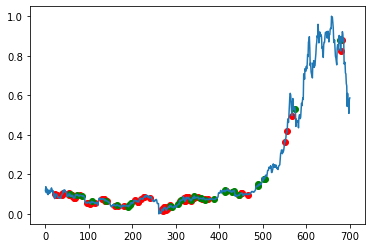

In [71]:
# predict using decision tree
DT = DecisionTreeClassifier(min_samples_split=5).fit(finaltrainX,finaltrainY) # fit decision tree

DTpredY = DT.predict(testX) # make predictions using model

testsignalsell = list()
testsignalbuy = list()
for k in range(len(DTpredY)):
    if DTpredY[k] == 'BUY':
        testsignalbuy.append(pricetestY.values[k])
        testsignalsell.append(0)
    elif DTpredY[k] == 'SELL':
        testsignalbuy.append(0)
        testsignalsell.append(pricetestY.values[k])
    else:
        testsignalbuy.append(0)
        testsignalsell.append(0)
        
testplotsell=pd.DataFrame(np.array(testsignalsell))
testplotbuy=pd.DataFrame(np.array(testsignalbuy))
pyplot.figure() # plot training data
pyplot.scatter(range(len(testsignalsell)),testplotsell[testplotsell!=0],color='red')
pyplot.scatter(range(len(testsignalbuy)),testplotbuy[testplotbuy!=0],color='green')
pyplot.plot(pricetestY)
pyplot.plot

## SIMULATION
trueprice=pd.DataFrame(data['close'].values)
testtrueprice=trueprice.iloc[len(data)-len(pricetestY):,]

money = 100000
state = 'HOLD'
shares = 0
for a in range(len(testtrueprice)):
    if DTpredY[a] == 'BUY' and state != 'BUY':
        shares = (money/testtrueprice.values[a])*0.99
        money = 0
        print('Bought at %.3f, Coins held: %.3f, Money now: %.2f' % (testtrueprice.values[a], shares/50, money))
        state = 'BUY'
    if DTpredY[a] == 'SELL' and state == 'BUY':
        money = shares*testtrueprice.values[a]*0.99
        shares = 0
        print('Sold at %.3f, Coins held: %.3f, Money now: %.2f' % (testtrueprice.values[a], shares/50, money))
        state = 'SELL'

<ipython-input-72-50042b4d82d8>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  testplotsell=pd.DataFrame(np.array(testsignalsell))
<ipython-input-72-50042b4d82d8>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  testplotbuy=pd.DataFrame(np.array(testsignalbuy))


Bought at 11751.010, Coins held: 0.168, Money now: 0.00
Sold at 39290.380, Coins held: 0.000, Money now: 327703.76


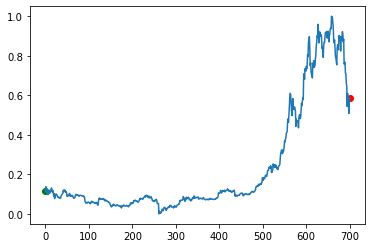

In [72]:
## HOLD
action=list()
action.append('BUY')
for a in range(len(testtrueprice)-2):
    action.append('HOLD')
action.append('SELL')

testsignalsell = list()
testsignalbuy = list()
for k in range(len(action)):
    if action[k] == 'BUY':
        testsignalbuy.append(pricetestY.values[k])
        testsignalsell.append(0)
    elif action[k] == 'SELL':
        testsignalbuy.append(0)
        testsignalsell.append(pricetestY.values[k])
    else:
        testsignalbuy.append(0)
        testsignalsell.append(0)
        
testplotsell=pd.DataFrame(np.array(testsignalsell))
testplotbuy=pd.DataFrame(np.array(testsignalbuy))
pyplot.figure() # plot training data
pyplot.scatter(range(len(testsignalsell)),testplotsell[testplotsell!=0],color='red')
pyplot.scatter(range(len(testsignalbuy)),testplotbuy[testplotbuy!=0],color='green')
pyplot.plot(pricetestY)
pyplot.plot

money = 100000
state = 'HOLD'
shares = 0
for a in range(len(testtrueprice)):
    if action[a] == 'BUY' and state != 'BUY':
        shares = (money/testtrueprice.values[a])*0.99
        money = 0
        print('Bought at %.3f, Coins held: %.3f, Money now: %.2f' % (testtrueprice.values[a], shares/50, money))
        state = 'BUY'
    if action[a] == 'SELL' and state == 'BUY':
        money = shares*testtrueprice.values[a]*0.99
        shares = 0
        print('Sold at %.3f, Coins held: %.3f, Money now: %.2f' % (testtrueprice.values[a], shares/50, money))